# Data

The dataset contains 5572 messages and their corresponding classification (spam or ham) in a DAT file.


# Problem Statement

This is a binary classification problem. The objective is to accurately classify messages as either spam or ham.


# Methodology

Various natural language processing techniques will be utilized in this analysis. Tasks include exploratory data analysis, data preprocessing, predictive modeling and model evaluation.

# 1. Import Libraries and Dataset

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

# Import Dataset
sms = pd.read_csv('SMSSpamCollection', sep='\t', names = ['label', 'message'])

# 2. Exploratory Data Analysis 

In [2]:
# Take a look at the data structure
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [3]:
# Top 5 entries
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


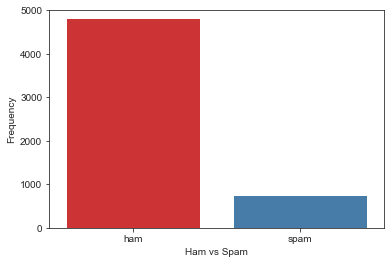

Percentage of Ham messages:  86.6 %
Percentage of Spam messages: 13.4 %


In [4]:
# Lets create a barchart of the response variable
sns.set_style('ticks')
#sns.set_palette('Set2')
sns.countplot(data=sms, x="label", order=["ham", "spam"], palette='Set1')
plt.xlabel('Ham vs Spam')
plt.ylabel('Frequency')
plt.ylim([0, 5000])
plt.show()


# Proportion of Spam vs Ham
x = sms['label'].value_counts(normalize=True)
print("Percentage of Ham messages: ", str(x['ham'].round(3) * 100), '%')
print("Percentage of Spam messages:", str(x['spam'].round(3) * 100), '%')

This is an unbalanced dataset. The proportion of Ham messages are significantly greater than the proportion of spam messages. The simple accuracy metric won't be a reliable indicator of model performance. It would be worth checking out the f1 score and paying closer attention to the false positive rate.

# 3. Data Preprocessing

 **3.1 Data Cleaning**
 
Before converting the textual data into its numerical representation, it is important to carry out data cleaning. The following transformations will be applied to the messages.

- Lowercase all words
- Remove puntuation marks and special characters
- Stemming and Lemmatization
- Removing stop-words
- Binary encode the independent variable
- Tokenization

In [5]:
corpus = []
for i in range(len(sms)): # Iterate for all tokenized sentences
    review = re.sub('[^a-zA-Z]', ' ', sms.message[i]) # replace everything that is not a letter with a blank space
    review = review.lower() # lowercase all letters
    review = review.split() # store each word seperately in a list
    stemmer = PorterStemmer() # Instantiate Porter Stemmer
    review = [stemmer.stem(word) for word in review if word not in set(stopwords.words('english'))] # Stem words
    review = ' '.join(review) # join the stemmed words back to review
    corpus.append(review) # add sentences to the corpus 

Lets take a look at the transformed data

In [6]:
# First 10 sentences
corpus[0:10]

['go jurong point crazi avail bugi n great world la e buffet cine got amor wat',
 'ok lar joke wif u oni',
 'free entri wkli comp win fa cup final tkt st may text fa receiv entri question std txt rate c appli',
 'u dun say earli hor u c alreadi say',
 'nah think goe usf live around though',
 'freemsg hey darl week word back like fun still tb ok xxx std chg send rcv',
 'even brother like speak treat like aid patent',
 'per request mell mell oru minnaminungint nurungu vettam set callertun caller press copi friend callertun',
 'winner valu network custom select receivea prize reward claim call claim code kl valid hour',
 'mobil month u r entitl updat latest colour mobil camera free call mobil updat co free']

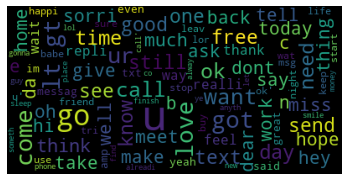

In [50]:
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=50)
wc = wc.generate(str(corpus))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

**3.2 Converting Text to Numbers**

Now that our data is cleaned up, we can transform it into a numerical vectorized format. One technique to accomplish this is by using the **Bag of Words** model. 

- Tokenize words and build a vocabulary by finding the set of unique words in the corpus. 

- Encoded each sentence as a fixed length vector with the length of the vocabulary. 

- Count the frequency of each word occuring in the sentence. If the word in the vocab appears in the sentence, the vector space will contain 1 for that feature, if the word appears twice, a 2 if the word doesnt appear at all, a 0.


In [7]:
# Instantiate Count Vectorizer
cv = CountVectorizer(max_features=5000)

# Create bag of words based numeric matrix
X = cv.fit_transform(corpus).toarray()


# Term Frequency Inverse Document Frequency
tfid = TfidfVectorizer(max_features=5000)

X1 = tfid.fit_transform(corpus).toarray()

Lets take a look at the transformed matrix

In [8]:
pd.DataFrame(np.array(X), columns = cv.get_feature_names()).head()

,aa,aah,aaniy,aaooooright,aathi,ab,abbey,abdomen,abeg,abel,...,zebra,zed,zero,zf,zhong,zindgi,zoe,zogtoriu,zoom,zouk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


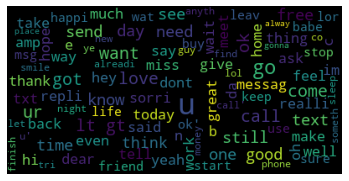

In [9]:
# One hot encoding the target variable
y = pd.get_dummies(sms['label'])

# Slice the spam column so 1 represents spam
y = y.iloc[:, 1].values

# 4. Predictive Modelling

In [10]:
# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

In [11]:
# Put models in a dictionary
algorithms = {"KNN": KNeighborsClassifier(),
              "Random Forest": RandomForestClassifier(),
              "SVC RBF": SVC(),
              "Decision Tree":DecisionTreeClassifier(),
              "Adaboost" :AdaBoostClassifier(),
              "XGBClassifier" : XGBClassifier(use_label_encoder=False, eval_metric = 'logloss'),
              "MultinomialNB" :MultinomialNB(),
              "GaussianNB" : GaussianNB(),
              "BernoulliNB": BernoulliNB()}


# Create function to train and test the models
def train_and_test(algorithms, X_train,y_train,X_test,y_test):
    model_scores = {}
    for name, model in algorithms.items():
        model.fit(X_train, y_train)
        print(name + " Accuracy: {:.2f}".format(model.score(X_test, y_test)))


model_scores = train_and_test(algorithms, X_train, y_train, X_test, y_test)

KNN Accuracy: 0.92
Random Forest Accuracy: 0.98
SVC RBF Accuracy: 0.98
Decision Tree Accuracy: 0.96
Adaboost Accuracy: 0.97
XGBClassifier Accuracy: 0.98
MultinomialNB Accuracy: 0.98
GaussianNB Accuracy: 0.88


We have a tie ! However, Naive Bayes traditionally perform really well with spam classification problems. I will therefore consider this model for further evaluation.

# 5. Evaluation

In [15]:
# Confusion Matrix & Classification Report

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

def evaluate_model(model, X_test):
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    clr = classification_report(y_test, y_pred, target_names=["Ham", "Spam"])
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.6, labels=["Ham", "Spam"])
    plt.yticks(ticks=np.arange(2) + 0.6, labels=["Ham", "Spam"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n---------------------\n", clr)

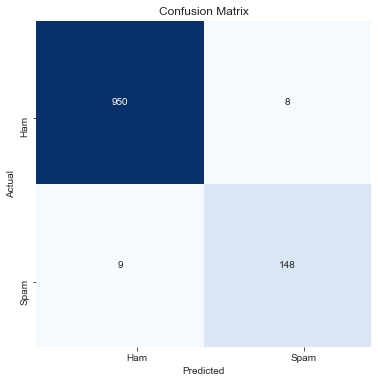

Classification Report:
---------------------
               precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       958
        Spam       0.95      0.94      0.95       157

    accuracy                           0.98      1115
   macro avg       0.97      0.97      0.97      1115
weighted avg       0.98      0.98      0.98      1115



In [16]:
evaluate_model(model, X_test)

In the context of spam sms classification, we give more consideration to false positives. Flagging a legitimate message as spam is more problematic than letting a spam message or two slip in your inbox ! Therefore, an ROC/AUC curve would be a good indicator of model performance.

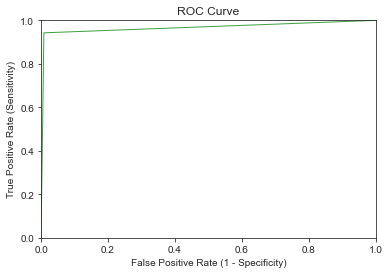

In [18]:
    # ROC/AUC Curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, c = 'green', linewidth = 1,alpha = 0.75)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.show()

In [42]:
msg = pd.Series([])
newsms = cv.transform(msg)
model.predict(newsms)

# 6. Conclusion

Overall the simple bag of words approach performs well at spam classification. It would be worth trying out lemmatization and tf-idf to see if we can further improve model performance. 